In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt 
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data=np.load(r'C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_11_18_sample_100x100x5mm_no_defect_isotropic_gaussian_heat_no_conv_cond_5.npz',allow_pickle=True)
# data=np.load(r'C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz',allow_pickle=True)
# data=np.load(r'/Volumes/KINGSTON/Synthetic_data_no_defect/2025_11_18_sample_100x100x5mm_no_defect_isotropic_gaussian_heat_no_conv_cond_5.npz')
# data=np.load(r'/Volumes/KINGSTON/Synthetic_data_no_defect/2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz')

In [4]:
data['meta']

array([['time', '18/11/2025 21:36:12'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '300'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '334'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '5.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [5]:
# Normalize temperature data with the envireoment
temp=data['data']
temp=(temp-temp.min())/(temp.max()-temp.min())
print(f"Temp min: {temp.min()} | Temp max: {temp.max()}")

Temp min: 0.0 | Temp max: 1.0


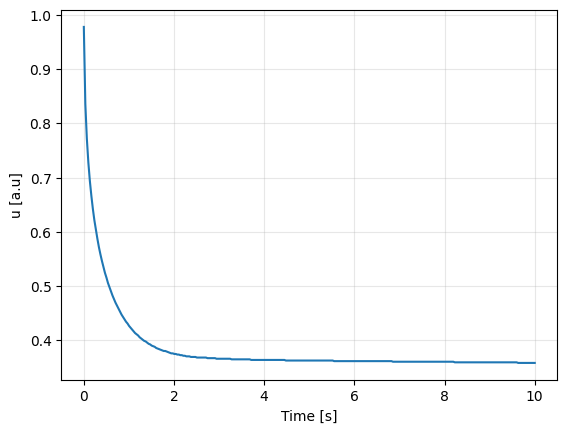

In [6]:
T,Y,X=temp.shape
y_center=Y//2
x_center=X//2
u_np=temp[34:,y_center,x_center]
x_plot=np.linspace(0,10,300)
plt.plot(x_plot,u_np)
plt.xlabel('Time [s]')
plt.ylabel('u [a.u]')
plt.grid(alpha=0.3)

In [7]:
print(f"Temp min: {u_np.min()} | Temp max: {u_np.max()}")

Temp min: 0.35792951541850226 | Temp max: 0.9779735682819384


In [8]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

        

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [9]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(2,1,100,4).to(device)

# Measured data
u=torch.from_numpy(u_np).to(torch.float32).view(-1,1)

In [10]:
t=torch.linspace(0,10,300).view(-1,1)
x_boundary=torch.zeros_like(u)

x_data=torch.hstack([t,x_boundary])
x_boundary_back=torch.tensor([0.0,0.1,10.0,0.1]).view(-1,2)
X=torch.concatenate([x_data,x_boundary_back],dim=0)

In [11]:
u_back=torch.tensor([0.0,0.0]).view(-1,1)
u_back
Y=torch.vstack([u,u_back])

In [12]:
# Collocation points
res=100 # Resolution parameter to our solution
time_res=3000
z_coll=torch.linspace(0,0.005,res)
t_coll=torch.linspace(0,10,time_res)

# Torch meshgrid only accept 1d tensors as input
T_mesh, X_mesh = torch.meshgrid(t_coll, z_coll, indexing='ij')
X_coll = torch.stack([T_mesh.reshape(-1), X_mesh.reshape(-1)], dim=1)

In [13]:
X=X.requires_grad_(True).to(device)
Y=Y.requires_grad_(True).to(device)
X_coll=X_coll.requires_grad_(True).to(device)
flux_at_boundary=torch.zeros_like(Y).requires_grad_(True).to(device)

In [14]:
n_epoch=100001

log_losses=[]
log_data_losses=[]
log_bnd_losses=[]
log_pde_losses=[]
log_a=[]

# We assume our starting point to be somewhere here
a_phys=5.0/(1600*700)
a = torch.log(torch.tensor([a_phys], dtype=torch.float32))
a=a.to(device)

optimiser=optim.Adam(pinn.parameters(),lr=1e-3)

for i in tqdm(range(n_epoch)):
  optimiser.zero_grad()
    
  # compute each term of the PINN loss function above
  # using the following hyperparameters
  lambda1, lambda2, lambda3 = 1, 1e-1, 1e-2

  # Calculate boundary loss data
  u_p=pinn(X)
  loss1=torch.mean((u_p-Y)**2)

  # Calculate Neuman boundary loss
  u_tx=torch.autograd.grad(u_p,X,torch.ones_like(u_p),create_graph=True)[0]
  u_t=u_tx[:,0].view(-1,1) # Time gradient
  u_x=u_tx[:,1].view(-1,1) # Space gradient
  loss2=torch.mean((u_x-flux_at_boundary)**2)

  # Calculate PDE loss
  u_coll=pinn(X_coll)
  u_coll_tx=torch.autograd.grad(u_coll,X_coll,torch.ones_like(u_coll),create_graph=True)[0]
  u_coll_t=u_coll_tx[:,0].view(-1,1) # Gradient in time
  u_coll_x=u_coll_tx[:,1].view(-1,1) # Gradient in space

  u_coll_xx=torch.autograd.grad(u_coll_x,X_coll,torch.ones_like(u_coll_x),create_graph=True)[0][:,1].view(-1,1)
    
  a_actual=torch.exp(a)
  f=u_coll_t-a_actual*u_coll_xx
  loss3=torch.mean(f**2)

  losses=lambda1*loss1+lambda2*loss2+lambda3*loss3    

  losses.backward()
  optimiser.step()

  log_losses.append(losses.item())
  log_data_losses.append(loss1.item())
  log_bnd_losses.append(loss2.item())
  log_pde_losses.append(loss3.item())
  log_a.append(a_actual.item())

  if i % 100 == 0:
    print(f"[{i}] "
          f"Total: {losses.item():.4e} | "
          f"Data: {loss1.item():.4e} | "
          f"Boundary: {loss2.item():.4e} | "
          f"PDE: {loss3.item():.4e}"
          f" | a: {a_actual.item():.4e}"
          )




  0%|          | 0/100001 [00:00<?, ?it/s]c:\Users\stone\Anisotropic_diffusivity_2\venv\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 3/100001 [00:00<3:50:34,  7.23it/s]

[0] Total: 1.6555e-01 | Data: 1.6551e-01 | Boundary: 3.5421e-04 | PDE: 2.8863e-04 | a: 4.4643e-06


  0%|          | 103/100001 [00:07<2:02:25, 13.60it/s]

[100] Total: 2.9375e-03 | Data: 2.9126e-03 | Boundary: 4.1715e-05 | PDE: 2.0685e-03 | a: 4.4643e-06


  0%|          | 203/100001 [00:15<2:01:53, 13.65it/s]

[200] Total: 2.5834e-03 | Data: 2.5398e-03 | Boundary: 5.9900e-05 | PDE: 3.7603e-03 | a: 4.4643e-06


  0%|          | 303/100001 [00:22<2:02:24, 13.57it/s]

[300] Total: 2.5261e-03 | Data: 2.4720e-03 | Boundary: 6.7307e-05 | PDE: 4.7396e-03 | a: 4.4643e-06


  0%|          | 403/100001 [00:29<2:02:00, 13.60it/s]

[400] Total: 2.4966e-03 | Data: 2.4369e-03 | Boundary: 7.3972e-05 | PDE: 5.2323e-03 | a: 4.4643e-06


  1%|          | 503/100001 [00:37<2:02:48, 13.50it/s]

[500] Total: 2.4809e-03 | Data: 2.4163e-03 | Boundary: 8.2350e-05 | PDE: 5.6389e-03 | a: 4.4643e-06


  1%|          | 551/100001 [00:40<2:02:48, 13.50it/s]


KeyboardInterrupt: 

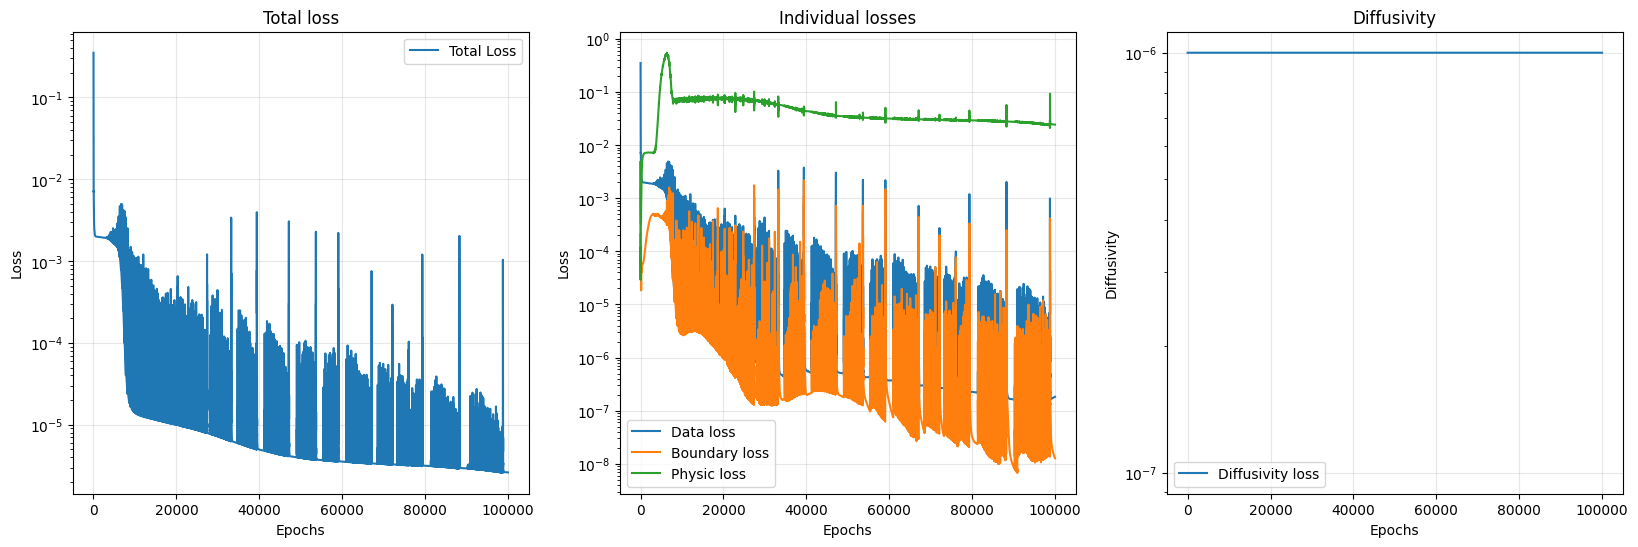

In [15]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.semilogy(log_losses, label='Total Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total loss")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,3,2)
plt.semilogy(log_data_losses, label='Data loss')
plt.semilogy(log_bnd_losses, label='Boundary loss')
plt.semilogy(log_pde_losses, label='Physic loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Individual losses")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,3,3)
plt.semilogy(log_a, label='Diffusivity loss')
plt.xlabel("Epochs")
plt.ylabel("Diffusivity")
plt.title("Diffusivity")
plt.legend()
plt.grid(alpha=0.3)



In [16]:
x_pred=pinn(X_coll)

Text(0.5, 1.0, 'Temperature profile at center point over time')

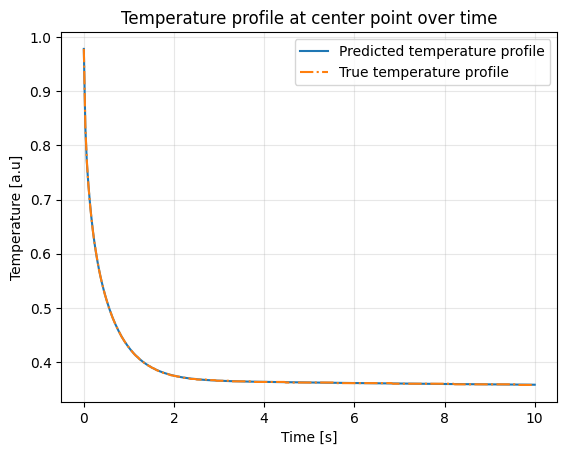

In [35]:
plt.plot(x_plot,x_pred[::100].detach().cpu().numpy(),label='Predicted temperature profile')
plt.plot(x_plot,u_np,label='True temperature profile',linestyle='-.')
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [a.u]')
plt.title('Temperature profile at center point over time')

Text(0.5, 1.0, 'Temperature profile at center point over time')

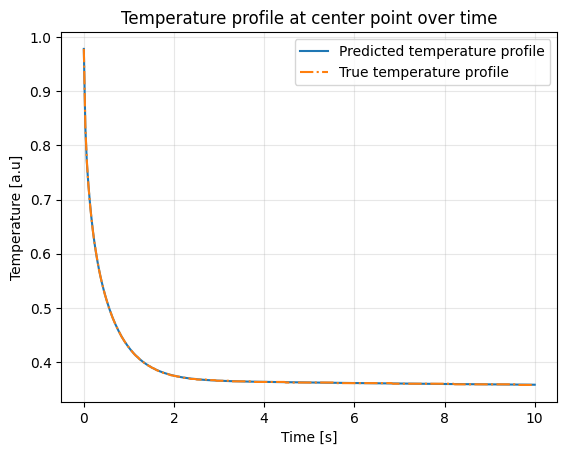

In [37]:
plt.plot(x_plot,x_pred[::100].detach().cpu().numpy(),label='Predicted temperature profile')
plt.plot(x_plot,u_np,label='True temperature profile',linestyle='-.')
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [a.u]')
plt.title('Temperature profile at center point over time')

In [39]:
x_pred=x_pred.reshape(300,100)

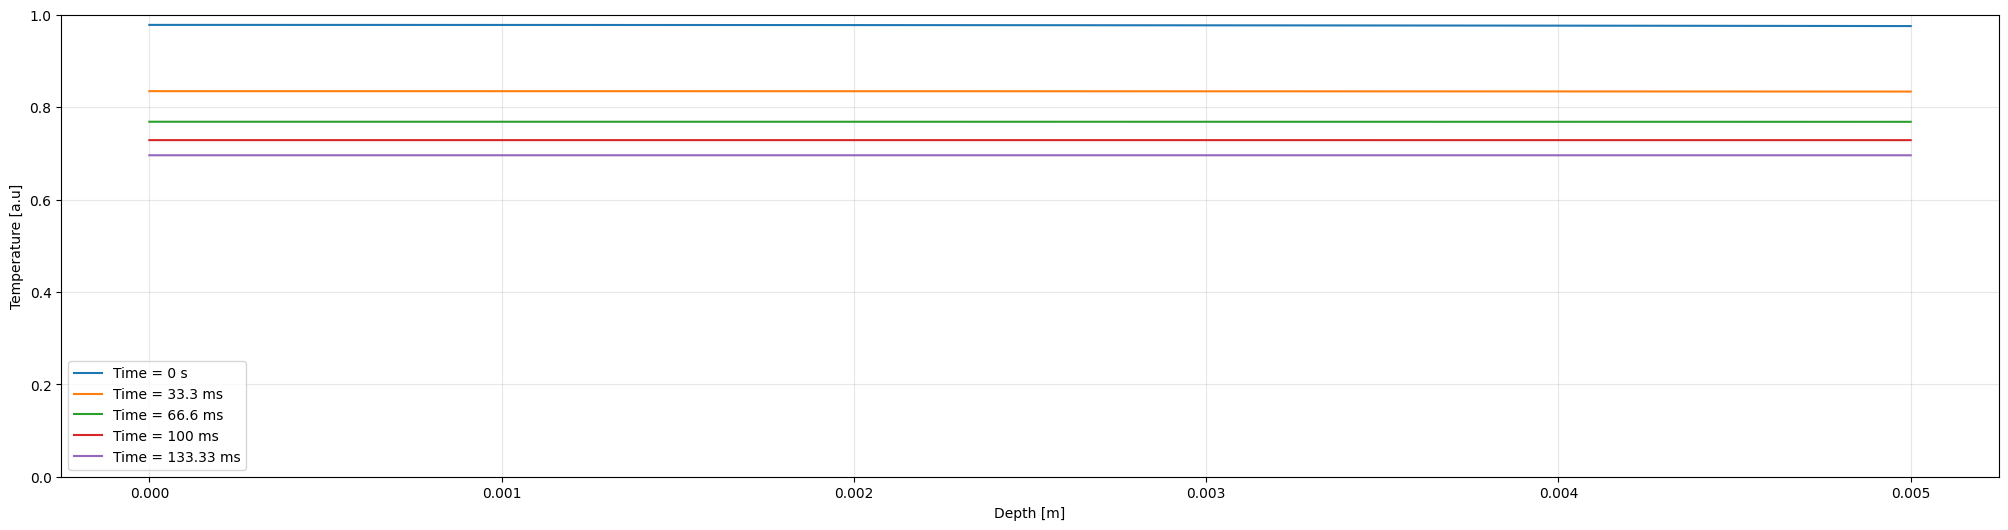

In [71]:
plt.figure(figsize=(25,6))

plt.plot(z_coll,x_pred[0,:].detach().cpu().numpy(),label=('Time = 0 s'))
plt.ylim(0,1)
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [a.u]')

plt.plot(z_coll,x_pred[1,:].detach().cpu().numpy(),label=('Time = 33.3 ms'))
plt.ylim(0,1)
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [a.u]')

plt.plot(z_coll,x_pred[2,:].detach().cpu().numpy(),label=('Time = 66.6 ms'))
plt.ylim(0,1)
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [a.u]')

plt.plot(z_coll,x_pred[3,:].detach().cpu().numpy(), label=('Time = 100 ms'))
plt.ylim(0,1)
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [a.u]')
plt.legend()
plt.grid(alpha=0.3)

plt.plot(z_coll,x_pred[4,:].detach().cpu().numpy(), label=('Time = 133.33 ms'))
plt.ylim(0,1)
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [a.u]')
plt.legend()
plt.grid(alpha=0.3)



In [ ]:
torch.save(pinn.state_dict(), 'pinn_1D_diffusivity_model_uniform_heating.pth')